In [13]:
from tqdm import tqdm
from QAOA.qaoa_src.Ansatz import *
import scipy as sc
from qiskit.visualization import plot_histogram

In [14]:
# Generating random graph 
n = 3
rng_seed = int(np.random.randint(0,2**31-1))
np.random.seed(rng_seed)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
edge_list = generate_random_graph(nodes=n,weighted=True,w_min=1e-2,seed=rng_seed)

# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(edge_list)


Best solution = [0 1 0] cost = -0.9392


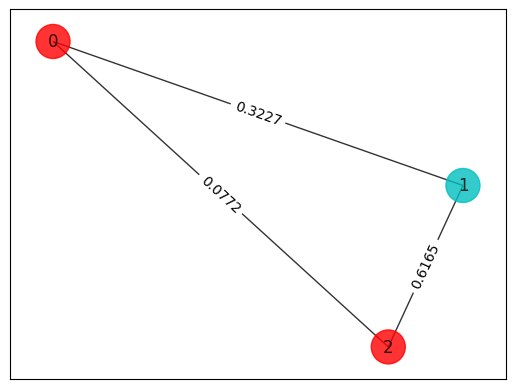

In [15]:
# Calculating optimal partition and plotting
best_cost, best_perm = qubo_min_cost_partition(nr_nodes=n,Q_mat=get_qubo(size=n,edges=edge_list))
colors = ["r" if best_perm[i] == 0 else "c" for i in range(n)]
print("\nBest solution = " + str(best_perm) + " cost = " + str(best_cost))
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)


In [25]:
# Defining instance of QAOA ansatz
QAOA_objective = QAOAansatz(n_qubits=n,w_edges=edge_list, backend="SYMQ", precision=64)


# Number of repetitions of (cost, mixer) in circuit
layers=6

# Initial guess for parameters (beta, gamma) of circuit
np.random.seed(0)
theta_min, theta_max = -np.pi, np.pi
gamma_i = np.random.uniform(low=theta_min, high=theta_max, size=layers).tolist()
beta_i = np.random.uniform(low=theta_min, high=theta_max, size=layers).tolist()
theta_i = gamma_i + beta_i

# Function to track optimization progress using tqdm
def callback(xk,*_):
    pbar.update(1)

# ------ Optimizer run ------ #

# Optimizer technique 1)
_available_methods_ = ['Nelder-Mead', 'Powell', 'COBYLA', 'trust-constr']
with tqdm(total=None, desc="Optimizing", ascii=True) as pbar:
    res = sc.optimize.minimize(fun=QAOA_objective.evaluate_circuit, x0=theta_i,method=_available_methods_[2],callback=callback, options={'disp': True, 'maxiter': 10000})

# Optimizer technique 2)
#res = sc.optimize.basinhopping(func=QAOA_objective.evaluate_circuit, x0=theta_i, niter=10, stepsize=0.75)

# Optimizer technique 3)
#_available_strategies_ = ['best1bin', 'best1exp', 'rand1exp', 'randtobest1exp', 'currenttobest1exp', 'best2exp', 'rand2exp', 'randtobest1bin', 'currenttobest1bin', 'best2bin', 'rand2bin', 'rand1bin']
#res = sc.optimize.differential_evolution(func=QAOA_objective.evaluate_circuit,bounds=[(theta_min, theta_max) for angle in theta_i], strategy=_available_strategies_[1],popsize=2, maxiter=50)

# Optimizer technique 4)
#_available_sampling_methods_ = ['simplicial', 'halton', 'sobol']
#res = sc.optimize.shgo(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], sampling_method=_available_sampling_methods_[2],callback=printx)

# Optimizer technique 5)
#res = sc.optimize.dual_annealing(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=1000)

# Optimizer technique 6)
#res = sc.optimize.direct(func=QAOA_objective.evaluate_circuit, bounds=[(theta_min, theta_max) for angle in theta_i], maxfun=400)

# Final parameters (beta, gamma) for circuit
theta_f = res.x.tolist()
res

Optimizing: 5975it [02:30, 39.71it/s]


   Normal return from subroutine COBYLA

   NFVALS = 5975   F =-9.064548E-01    MAXCV = 0.000000E+00
   X = 1.514066E+00   1.283560E+00   2.099265E+00   6.792416E-01   5.559417E-01
       1.081729E+00  -9.700646E-01   2.244764E+00   3.187189E+00  -1.530694E+00
       3.053503E+00  -5.379527E-02


     fun: -0.9064547578565734
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 5975
  status: 1
 success: True
       x: array([ 1.51406607,  1.28356037,  2.09926487,  0.67924162,  0.5559417 ,
        1.08172943, -0.97006463,  2.2447641 ,  3.18718941, -1.53069376,
        3.05350273, -0.05379527])

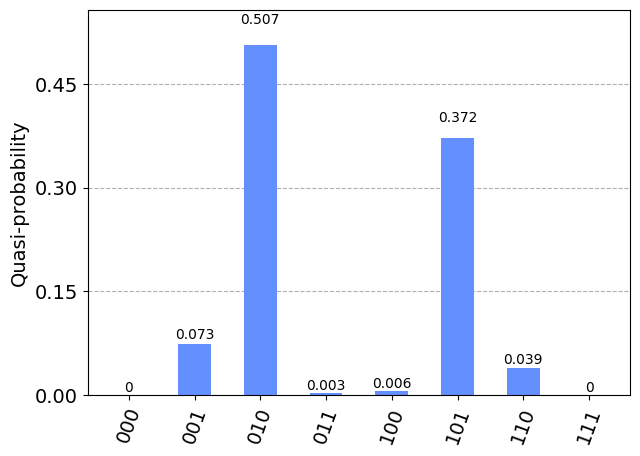

In [26]:
plot_histogram(QAOA_objective.set_circuit(theta=theta_f).get_state_probabilities(reverse_states=True))
